In [1]:
import sys
sys.path.append("/awlab/Lab_temp/ALS_Team/qj_test_folder/Imaging/maps_multiscreen/maps/")

import json
import importlib

import pandas as pd
import polars as pl
import numpy as np
import torch

from maps.multiscreen import config
import maps.multiscreen.data_loaders as data_loaders
import maps.multiscreen.aligners as aligners
import maps.multiscreen.fitting as fitting
import maps.multiscreen.evaluate as evaluate
import maps.multiscreen.visualizers as visualizers

# --- Initialize parameters ---
pdir = "/awlab/Lab_temp/ALS_Team/qj_test_folder/Imaging/maps_multiscreen/maps/template_analyses/params/"
with open(pdir + "binary_multiscreen-split-train.json", "r") as f:
    train_params = json.load(f)

with open(pdir + "binary_multiscreen-split-test.json", "r") as f:
    test_params = json.load(f)
    
PALETTE = {
    "WT": "#9A9A9A",
    "FUS": "#B24745" ,
    "C9orf72": "#6A6599",
    "sporadic": "#79AF97",
    "SOD1": "#00A1D5",
    "TDP43": "#DF8F44"
}

screen_mapping = {
    "2024042034": "20250407_AWALS39_FUS-focused_screen",
    "2024042012": "20241118_AWALS35_intermediate_screen_n72",
    "2024042039": "20250626_AWALS45_Full_screen_n_96",
    "2024042020": "20250216_AWALS37_Full_screen_n96"
}

/home/qyap/miniconda3/envs/maps_multi_screen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reading Data

In [2]:
from maps.screens import ImageScreen
from maps.analyses import MAP

train_screen = ImageScreen(train_params)
train_screen.load(antibody='FUS/EEA1')

test_screen = ImageScreen(test_params)
test_screen.load(antibody='FUS/EEA1')

print("Processing training set...")
train_screen.preprocess()

print("Processing test set...")
test_screen.preprocess()

print(f"Train data: {train_screen.data.shape}")
print(f"Test data: {test_screen.data.shape}")

Processing training set...


/awlab/Lab_temp/ALS_Team/qj_test_folder/Imaging/maps_multiscreen/maps/maps/processing.py:183: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sample(


Processing test set...
Train data: (17506, 309)
Test data: (15053, 309)


/awlab/Lab_temp/ALS_Team/qj_test_folder/Imaging/maps_multiscreen/maps/maps/processing.py:183: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sample(


In [3]:
train_screen.metadata = train_screen.metadata.with_columns(
    pl.col('CellLines').str.replace('11', '#11')
)
train_screen.metadata = train_screen.metadata.with_columns(
    pl.col('CellLines').str.replace('##11', '#11')
)
test_screen.metadata = test_screen.metadata.with_columns(
    pl.col('CellLines').str.replace('11', '#11')
)
test_screen.metadata = test_screen.metadata.with_columns(
    pl.col('CellLines').str.replace('##11', '#11')
)

# Aligner

In [5]:
importlib.reload(config)
importlib.reload(data_loaders)
importlib.reload(aligners)
importlib.reload(fitting)

torch.manual_seed(1126)

dataloader_config = config.DataLoaderConfig()
fit_config = config.FitConfig()
aligner_config = config.AlignerConfig()
aligner_config.n_domains = 4

transformer = fitting.DataTransformer(aligner_class=aligners.DANNAligner, 
                                      fit_config=fit_config)
train_data_transform = transformer.fit_transform(train_screen.data, train_screen.metadata,
                                                    dataloader_config,
                                                    aligner_config)

Training aligner DANNAligner with 4 domains...
26 cell line labels
Epoch 10/100, Alpha: 0.422, Domain Loss: 0.5701, Label Loss: 2.2415
Epoch 20/100, Alpha: 0.740, Domain Loss: 1.1704, Label Loss: 2.2498
Epoch 30/100, Alpha: 0.896, Domain Loss: 1.2290, Label Loss: 2.2164
Epoch 40/100, Alpha: 0.960, Domain Loss: 1.2433, Label Loss: 2.1619
Epoch 50/100, Alpha: 0.985, Domain Loss: 1.2412, Label Loss: 2.1246
Epoch 60/100, Alpha: 0.995, Domain Loss: 1.2475, Label Loss: 2.0746
Epoch 70/100, Alpha: 0.998, Domain Loss: 1.2453, Label Loss: 2.0504
Epoch 80/100, Alpha: 0.999, Domain Loss: 1.2542, Label Loss: 2.0392
Epoch 90/100, Alpha: 1.000, Domain Loss: 1.2531, Label Loss: 2.0104
Epoch 100/100, Alpha: 1.000, Domain Loss: 1.2550, Label Loss: 2.0009


# Embedding Plot on Train Data

In [6]:
import umap

reducer = umap.UMAP(random_state=42)
umap_embeddings = reducer.fit_transform(
    train_data_transform[[f'aligned_feature_{i}' for i in range(aligner_config.output_dim)]]
)
umap_embeddings = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2']).merge(
    train_data_transform.loc[:, ~train_data_transform.columns.str.contains("aligned")], left_index=True, right_index=True
)
umap_embeddings['Screen'] = umap_embeddings['Screen'].map(screen_mapping).apply(lambda x: x.split('_')[1])

/home/qyap/miniconda3/envs/maps_multi_screen/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


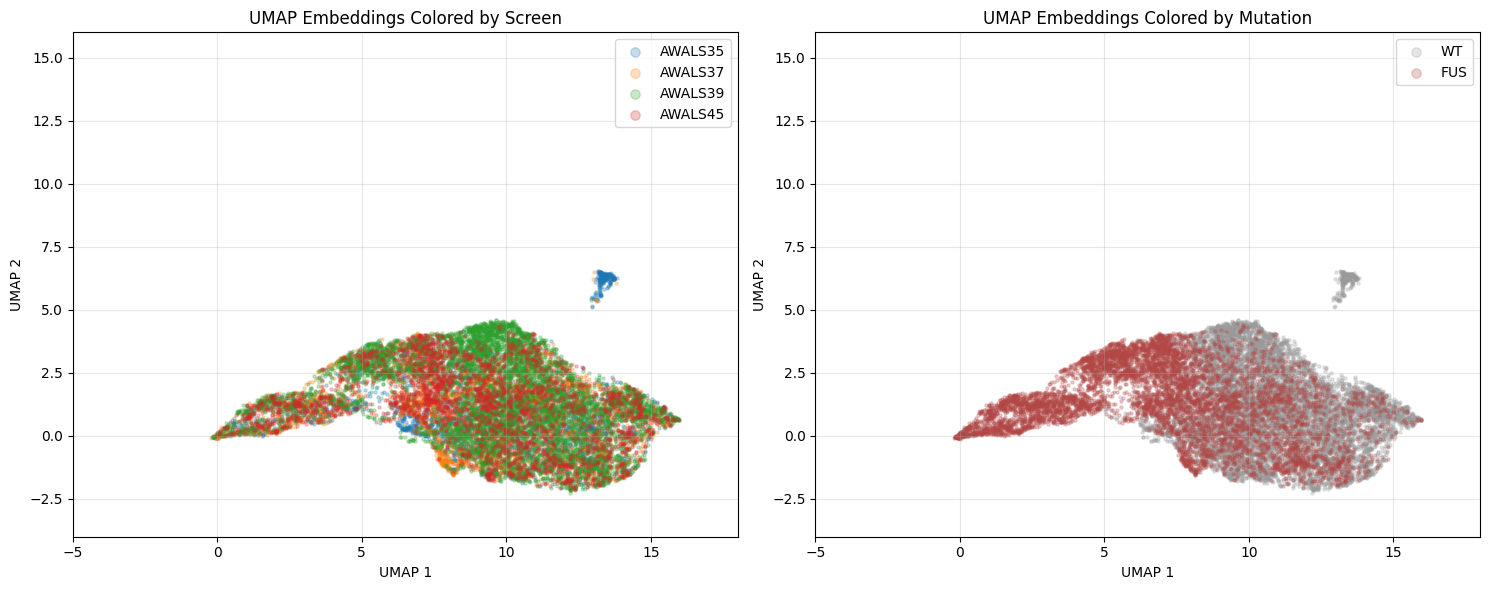

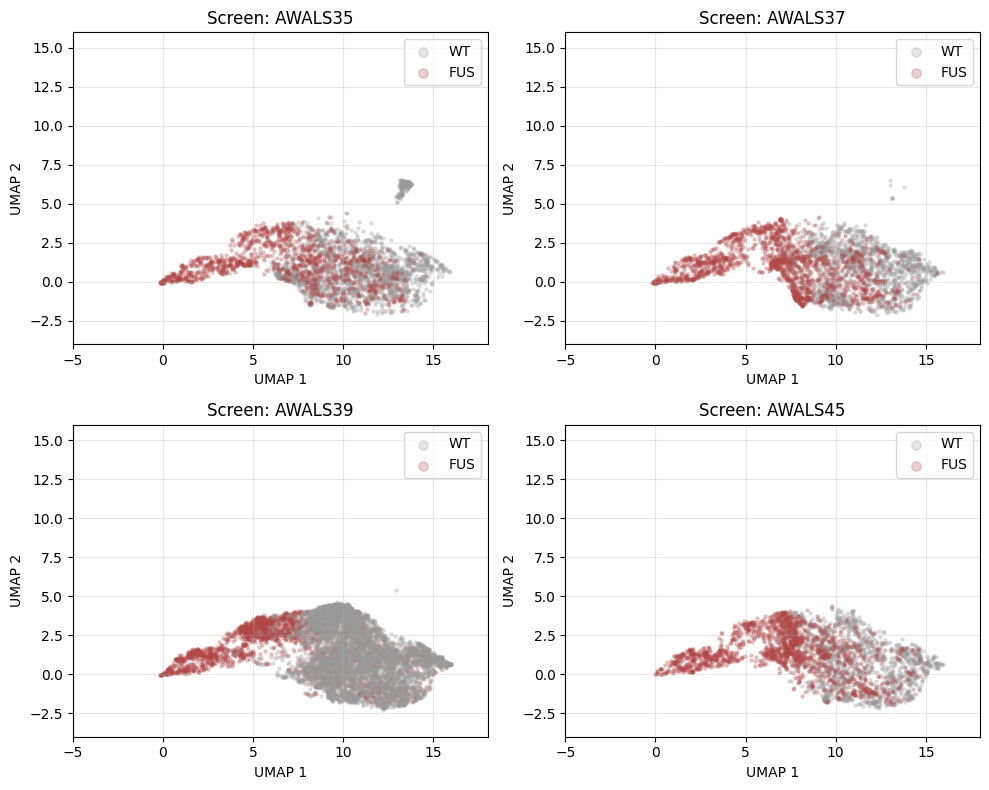

In [14]:
importlib.reload(visualizers)

visualizers.plot_umap_embeddings(umap_embeddings, x_limits=(-5, 18), y_limits=(-4, 16))
visualizers.plot_umap_embeddings_stratified(umap_embeddings, x_limits=(-5, 18), y_limits=(-4, 16))

# Embedding Plot on Test Data

In [9]:
test_data_transform = transformer.transform(test_screen.data, test_screen.metadata, 
                                            dataloader_config,
                                            aligner_config)
reducer = umap.UMAP(random_state=42)
umap_embeddings_test = reducer.fit_transform(
    test_data_transform[[f'aligned_feature_{i}' for i in range(aligner_config.output_dim)]]
)
umap_embeddings_test = pd.DataFrame(umap_embeddings_test, columns=['UMAP1', 'UMAP2']).merge(
    test_data_transform.loc[:, ~test_data_transform.columns.str.contains("aligned")], left_index=True, right_index=True
)
umap_embeddings_test['Screen'] = umap_embeddings_test['Screen'].map(screen_mapping).apply(lambda x: x.split('_')[1])

/home/qyap/miniconda3/envs/maps_multi_screen/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


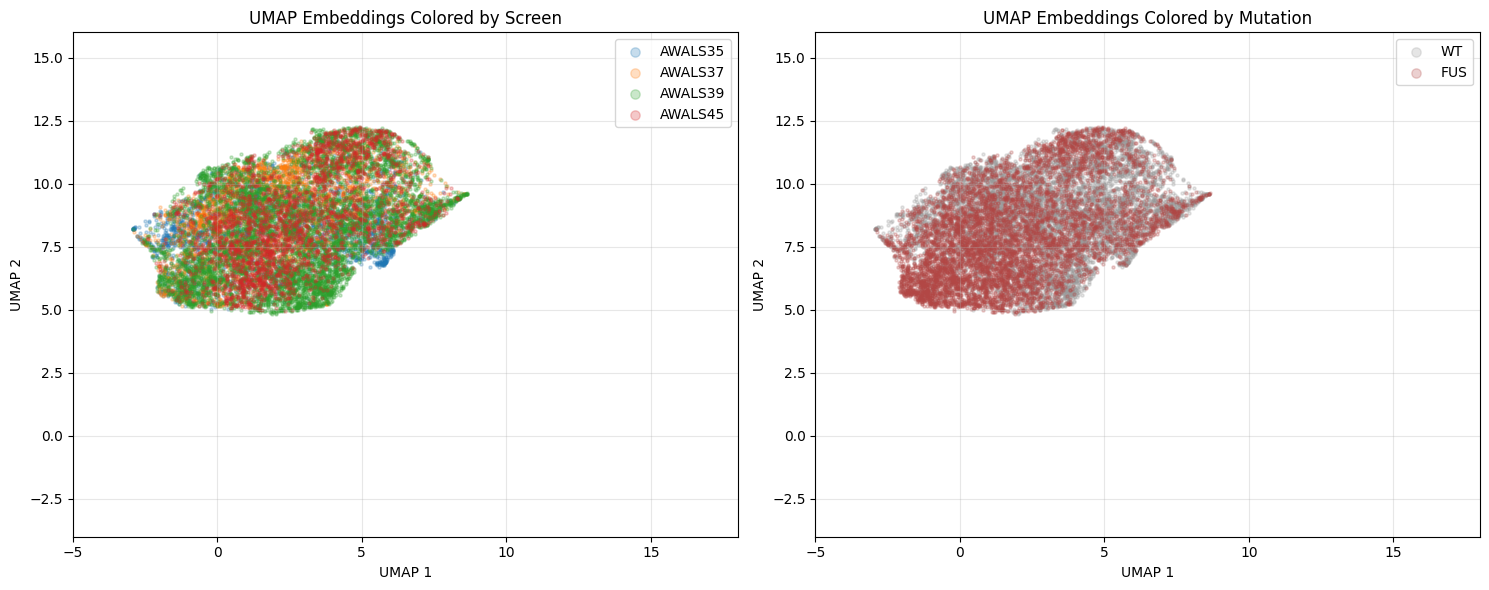

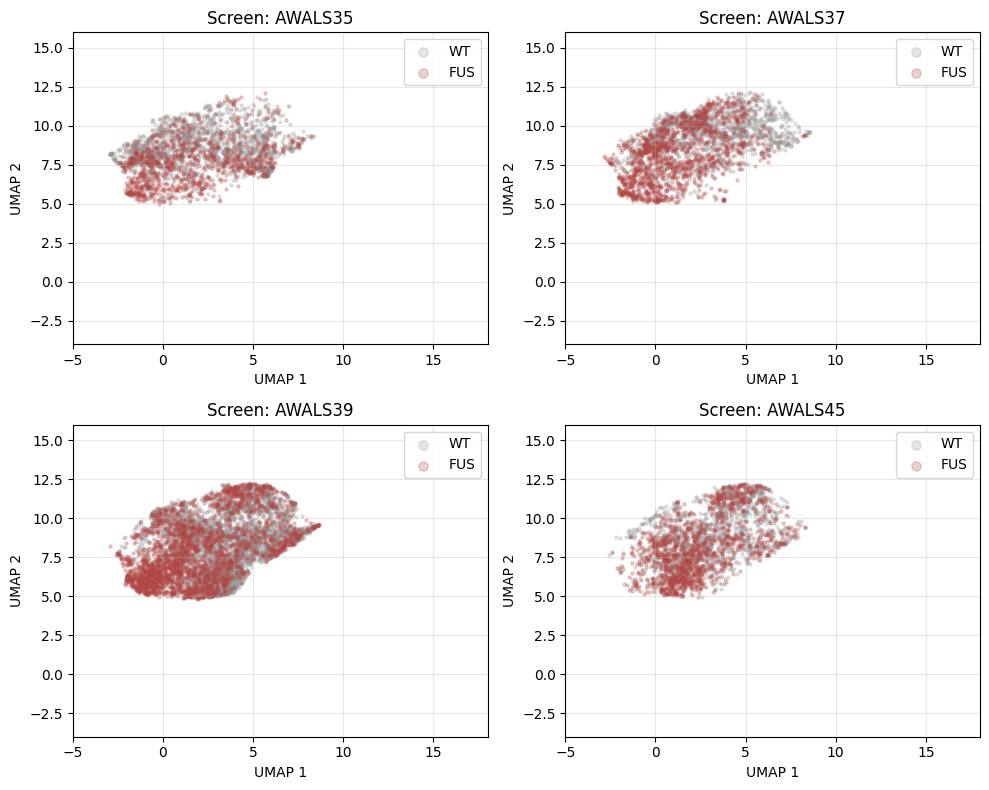

In [15]:
importlib.reload(visualizers)

visualizers.plot_umap_embeddings(umap_embeddings_test, x_limits=(-5, 18), y_limits=(-4, 16))
visualizers.plot_umap_embeddings_stratified(umap_embeddings_test, x_limits=(-5, 18), y_limits=(-4, 16))

# Cosine Similarity Metrics

In [ ]:
celllines_in_all_screens = train_data_transform[['CellLines', 'Screen']].drop_duplicates().groupby('CellLines').count()['Screen'] == 4
overlapping_cell_lines = celllines_in_all_screens[celllines_in_all_screens].index
overlapping_cell_lines

Index(['#11', 'ALS1', 'ALS15', 'ALS18', 'FTD73', 'GIH91', 'ND39027', 'NS002',
       'NS003', 'NS020', 'NS034', 'NS045'],
      dtype='object', name='CellLines')

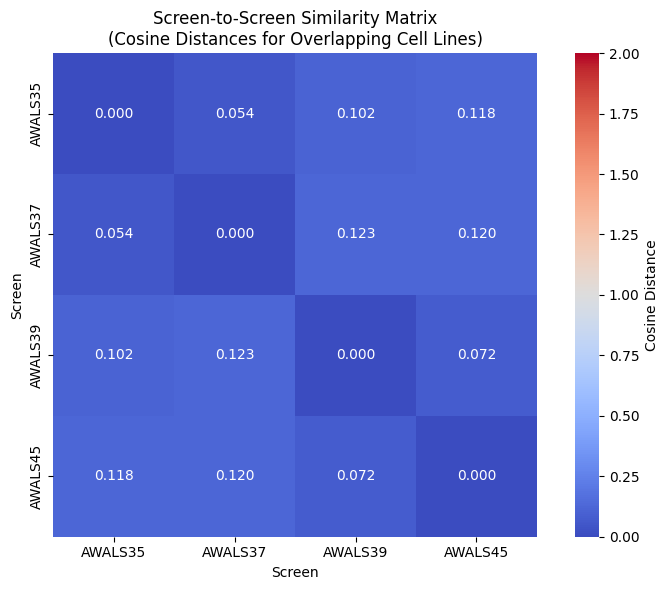

In [10]:
importlib.reload(evaluate)
import matplotlib.pyplot as plt
import seaborn as sns

similarity_matrix = evaluate.create_similarity_matrix(train_data_transform.drop(columns=['Screen', 'ID', 'Mutations']),
                                        train_data_transform['Screen'],
                                        overlapping_cell_lines)
# Map the screen IDs to readable names for the heatmap
similarity_matrix_mapped = similarity_matrix.copy()
similarity_matrix_mapped.index = similarity_matrix_mapped.index.map(screen_mapping).str.split('_').str[1]
similarity_matrix_mapped.columns = similarity_matrix_mapped.columns.map(screen_mapping).str.split('_').str[1]

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix_mapped.astype(float), 
            annot=True, 
            cmap='coolwarm', 
            square=True, 
            fmt='.3f',
            vmin=0,
            vmax=2,
            cbar_kws={'label': 'Cosine Distance'})
plt.title('Screen-to-Screen Similarity Matrix\n(Cosine Distances for Overlapping Cell Lines)')
plt.xlabel('Screen')
plt.ylabel('Screen')
plt.tight_layout()
plt.show()